<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas e funções

In [12]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator

In [13]:
def t6_perceptron(classe1, classe2, rho=0.05,maxsteps=10000):
    #Perceptron para duas classes
    #INPUTS:
    # - classe 1: L x N1 da primeira classe (características x padrões)
    # - classe 2: L x N2 da segunda classe (características x padrões)
    # - rho: learning parameter
    # - maxsteps = numero maximo de iteracoes
    #OUTPUT:
    # - ws: vetor com os pesos do classificador
    # - hs: indica se perceptron convergiu (1) ou não convergiu (0)
    # - t: número de iterações realizadas
    L1,N1=np.shape(classe1)
    L2,N2=np.shape(classe2)
    if L1!=L2:
        print('ERRO: Classes devem ter o mesmo número de características')
        return
    X=np.hstack((classe1, classe2))
    C=np.hstack((-np.ones(N1,),np.ones(N2,)))
    X=np.vstack((X,np.ones((1,N1+N2))))
    w=np.random.randn(L1+1,)
    ws=w;
    def classifica(w,X,C):
        res=np.sign(np.dot(w.T,X))
        Y=X[:,res*C<=0]
        CY=-C[res*C<=0]
        return Y, CY
    (Y,CY)=classifica(w,X,C)
    hs=np.shape(Y)[1]
    t=0
    while ((hs>0) & (t<maxsteps)):
        for i in range(L1+1):
            w[i]=w[i]-np.sum(rho*Y[i,:]*CY)
        [Y,CY]=classifica(w,X,C)
        t=t+1;
        ht=np.shape(Y)[1]
        if ht<hs:
            hs=ht
            ws=w
    if hs==0:
        print('Perceptron convergiu')
    else:
        print('Limite de interacoes atingido')
    return ws, hs, t

In [14]:
def t6_plotaperceptron(classe1,classe2,w,titulo,angulo=(-140,40)):
    #Faz o gráfico do Perceptron (para 2 ou 3 características)
    # Inputs:
    # - classe 1: L x N1 da primeira classe (características x padrões)
    # - classe 2: L x N2 da segunda classe (características x padrões)
    # - w = vetor de pesos do perceptron
    # - titulo = string com o titulo do grafico
    # - angulo = angulo de visualização (para o caso de 3 características)
    L=np.size(w) #dimensão do Perceptron (estendida, ou seja = número de características + 1)
    if L==3:
        plt.figure()
        plt.plot(classe1[0,:],classe1[1,:],'bo',fillstyle='none')
        plt.plot(classe2[0,:],classe2[1,:],'ro',fillstyle='none')
        x1=plt.xlim()[0]
        x2=plt.xlim()[1]
        x=np.linspace(x1,x2,1000)
        y=-(w[0]*x+w[2])/w[1]
        plt.plot(x,y,'--')
        plt.title(titulo)
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')
        plt.show()
    elif L==4:
        plt.figure()
        ax=plt.axes(projection='3d')
        ax.plot(classe1[0,:],classe1[1,:],classe1[2,:],'bo',fillstyle='none')
        ax.plot(classe2[0,:],classe2[1,:],classe2[2,:],'ro',fillstyle='none')
        x=ax.get_xlim()
        y=ax.get_ylim()
        (xx,yy)=t8_makemeshgrid(np.asarray(x), np.asarray(y),0.01)
        z = (-w[0]*xx -w[1]*yy -w[3])/w[2];
        ax.plot_surface(xx,yy,z,edgecolor='none')
        ax.view_init(angulo[0],angulo[1])
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        plt.show()
    else:
        print('ERRO: apenas para 2 ou 3 dimensões')

In [15]:
def t7_LS(classe1, classe2, c=0):
    #Classificador LS para duas classes.
    #INPUTS:
    # - classe 1: L x N1 da primeira classe
    # - classe 2: L x N2 da segunda classe
    # - c: parametro de regularidade (controla a singularidade da matriz de
    # correlacao)
    #OUTPUT:
    # - w: vetor com os pesos do classificador linear (ultimo elemento é o termo não
    # homogeneo)
    L1,N1=np.shape(classe1)
    L2,N2=np.shape(classe2)
    if L1!=L2:
        print('ERRO: Classes devem ter o mesmo número de características')
        return
    X=np.hstack((classe1, classe2))
    X=np.vstack((X,np.ones((1,N1+N2))))
    y=np.hstack((-np.ones(N1,),np.ones(N2,)))
    w=np.dot(np.linalg.inv(np.dot(X,X.T)+c*np.eye(L1+1)),np.dot(X,y));
    return w

In [16]:
def t7_FDA(classes,n):
    # Encontra a transformação para o espaço da Analise Discriminante Linear de Fisher entre classes distintas
    # INPUT:
    # - classes: lista de classes. classes[i]= (L x Ni): L caracteristicas e Ni padroes na classe i
    # - n = numero de caracterisiticas para selecionar
    # OUTPUT:
    # - A: matriz de projecao (as colunas sao os vetores de projecao para o novo espaço)
    # - Lambda: autovalores
    C=len(classes)
    L=np.size(classes[0],axis=0)
    for i in range(C):
        if np.size(classes[i],axis=0)!=L:
            print('ERRO: Confira a dimensao das variaveis de input')
            return
    SW,SM,SB=t3_matrizesdeespalhamento(classes,range(L))
    (Lambda,Vec)=np.linalg.eig(np.dot(np.linalg.inv(SW),SB))
    s=Lambda.argsort()
    Lambda=Lambda[s[::-1]]#ordem decrescente
    Vec=Vec[:,s[::-1]]#ordem decrescente
    A=np.real(Vec[:,0:n])
    Lambda=Lambda[0:n]
    return A,Lambda

In [118]:
def gerandodadosgaussianos(medias,covariancias,N,priors,plotar=True, seed=0,angulo=[0,0]):
    # Essa funcao gera um conjunto de dados simulados representando um
    # determinado numero de caracteristicas em um determinado numero de classes.
    # As classes possuem medias distintas e covariancias distintas. Os dados
    # seguem uma distribuicao gaussiana.
    # INPUT:
    # -medias =  classes x caracteristicas (matriz contendo as medias das
    #    caracteristica para cada classe)
    # -covariancia =  classes x caracteristicas x caracteristicas (matrizes de
    #    covariancia para cada classe)
    # -N = numero de padroes a serem gerados
    # -priors = classes x 1 (prior de cada classe: probabilidade de um padrao
    #    pertencer a cada classe)
    # - plotar = True (faz grafico - 2 ou tres dimensoes), False (nao faz grafico)
    # -seed = controle do seed na geracao de dados aleatorios
    # - angulo = angulo da visualizacao em caso de plot 3d.
    #
    # OUTPUT:
    # - dadossim=caracteristicas x padroes: dados simulados
    # - classessim= vetor contendo o numero da classe (de 0 ate C-1) de
    #     cada padrao simulado.
    M,L=np.shape(medias)
    if np.size(covariancias,axis=0)!=M |  np.size(covariancias,axis=1)!=L | np.size(covariancias,axis=2)!=L :
        print('Erro: confira a dimensao dos seus dados de input.')
        return
    if np.size(priors)!=M :
        print('Erro: confira a dimensao dos priors.')
        return
    if np.sum(priors)!=1 :
        print('Erro: confira os valores dos priors.')
        return
    Ni=tuple(np.round(priors*N))
    np.random.seed(seed)
    for i in range(M):
       if np.all(np.linalg.eigvals(covariancias[i]) > 0)==False :
           print('Erro: confira os valores da covariancia.')
       x=np.random.multivariate_normal(medias[i],covariancias[i],size=int(Ni[i]))
       if i==0:
           dadossim=x.T
           classessim=np.zeros(int(Ni[i]),)
       else:
           dadossim=np.concatenate((dadossim,x.T),axis=1)
           classessim=np.concatenate((classessim,np.zeros(int(Ni[i]),)+i),axis=0)

    if plotar:
        if L==2: #2 caracteristicas, plot 2d
            plt.figure()
            for i in range(M):
                plt.plot(dadossim[0,classessim==i],dadossim[1,classessim==i],'o',fillstyle='none')
            plt.xlabel('Dim 1')
            plt.ylabel('Dim 2')
            plt.show()
        elif L==3:
            plt.figure()
            ax=plt.axes(projection='3d')
            for i in range(M):
                ax.plot(dadossim[0,classessim==i],dadossim[1,classessim==i],dadossim[2,classessim==i],'o',fillstyle='none')
            ax.view_init(angulo[0],angulo[1])
            ax.set_xlabel('Dim 1')
            ax.set_ylabel('Dim 2')
            ax.set_zlabel('Dim 3')
            plt.show()
        else:
            print('Grafico é exibido apenas para 2 ou 3 dimensões')
    return dadossim, classessim

# Perceptron

**1) [Perceptron Pocket]**: No github do curso, você encontra uma função que implementa o classificador linear Perceptron para duas classes (“t6_perceptron” em “main.py”). A função recebe duas matrizes correspondendo a dados provenientes de duas classes distintas. As matrizes devem ter o mesmo número de características (L), mas podem ter números de padrões distintos. Além disso, a função recebe um número máximo de iterações e o parâmetro de aprendizagem do classificador (ρ). O algoritmo retorna o vetor em L+1 dimensões com os pesos do classificador linear.

**a)** Leia com calma a função para garantir que você compreende o que está sendo feito.

**b)** Agora vamos testá-la. No material de aula no Classroom você encontrará um arquivo chamado “dadosex1.mat” contendo cinco conjuntos de dados, “Classe1”, “Classe2a”, “Classe2b”, “Classe2c”, “Classe2d”. O primeiro conjunto corresponde aos dados da primeira classe e os demais conjuntos a 4 versões diferentes para os dados da segunda classe. Classe2a é o conjunto mais distante de Classe1. Classe2b e 2c são menos distantes, mas ainda linearmente separáveis da Classe 1. Por fim, Classe2d não é linearmente separável da Classe 1. Teste a velocidade do perceptron para a separação entre a classe 1 e a classe 2 para cada caso usando dois valores do parâmetro de aprendizagem ρ = 0 05 e ρ = 0.01. O que você pode concluir desses dados? Você consegue reproduzir figuras semelhantes com as figuras que estão a seguir? É claro que o plano do seu Perceptron poderá variar em relação às figuras abaixo. E note que há uma função pronta no material do curso para gerar os gráficos de um classificador linear qualquer em duas ou três dimensões (método “t6_plotaperceptron”). Use esta função para gerar os gráficos neste e nos demais problemas desta aula, se você assim preferir.

In [54]:
# leitura dos dados
class_1 = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe1']
class_2a = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2a']
class_2b = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2b']
class_2c = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2c']
class_2d = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2d']

Perceptron convergiu


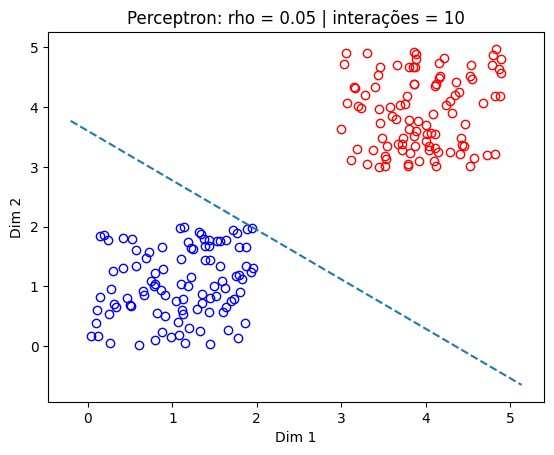

None
Perceptron convergiu


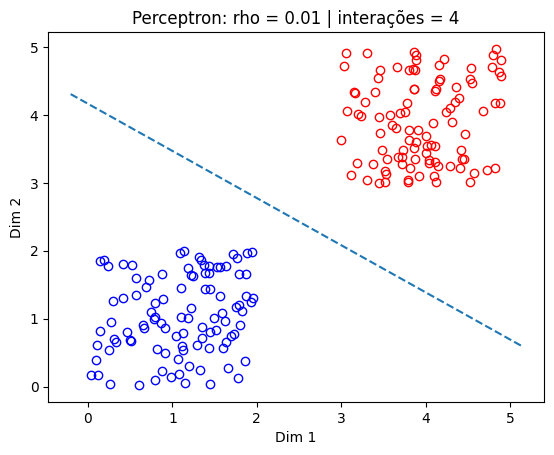

None


In [61]:
# aplicacao do perceptron entre a classe 1 e variantes da classe 2
# testando com rho 0.05 e 0.01

rho = [0.05, 0.01]
for index in range(len(rho)):
  ws_12a, hs_12a, t_12a = t6_perceptron(class_1, class_2a, rho=rho[index],maxsteps=10000)
  print(t6_plotaperceptron(class_1, class_2a, ws_12a, f"Perceptron: rho = {rho[index]} | interações = {t_12a}", angulo=(-140, 40)))

Perceptron convergiu


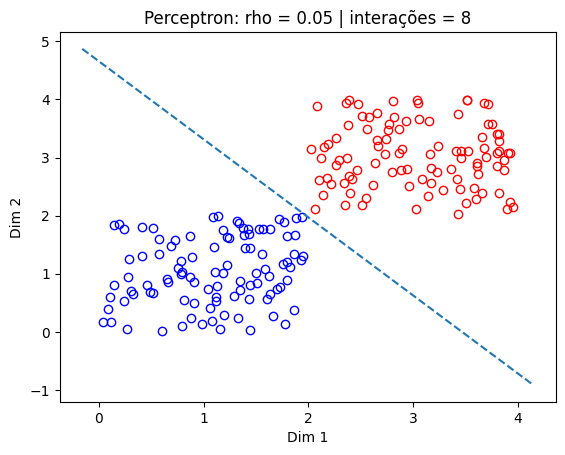

None
Perceptron convergiu


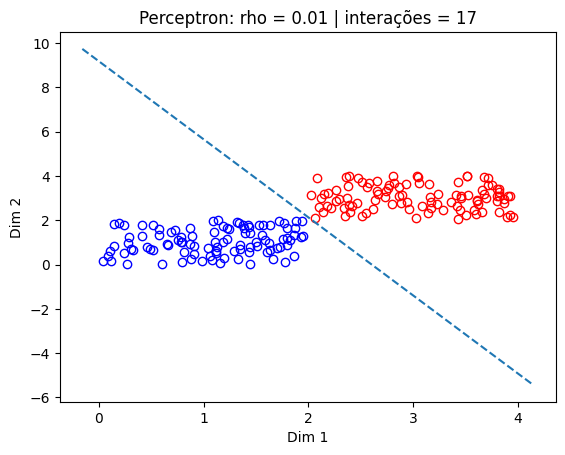

None


In [19]:
# aplicacao do perceptron entre a classe 1 e variantes da classe 2
# testando com rho 0.05 e 0.01

rho = [0.05, 0.01]
for index in range(len(rho)):
  ws_12b, hs_12b, t_12b = t6_perceptron(class_1, class_2b, rho=rho[index],maxsteps=10000)
  print(t6_plotaperceptron(class_1, class_2b, ws_12b, f"Perceptron: rho = {rho[index]} | interações = {t_12b}", angulo=(-140, 40)))

Perceptron convergiu


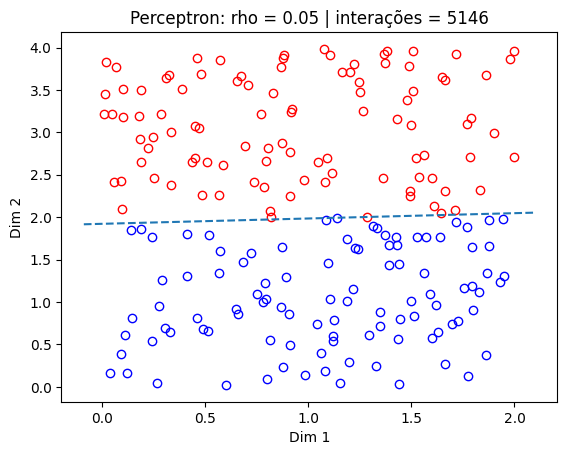

None
Perceptron convergiu


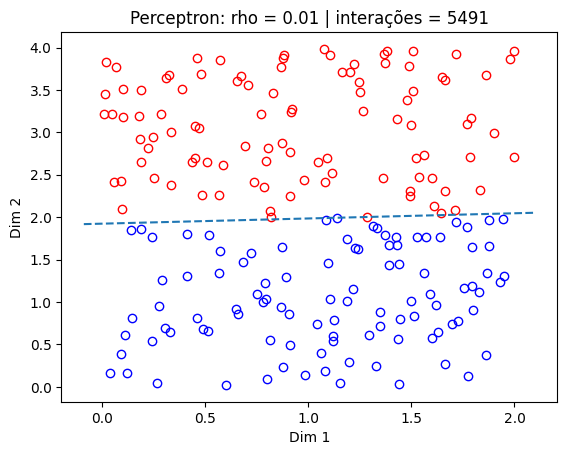

None


In [20]:
# aplicacao do perceptron entre a classe 1 e variantes da classe 2
# testando com rho 0.05 e 0.01

rho = [0.05, 0.01]
for index in range(len(rho)):
  ws_12c, hs_12c, t_12c = t6_perceptron(class_1, class_2c, rho=rho[index],maxsteps=10000)
  print(t6_plotaperceptron(class_1, class_2c, ws_12c, f"Perceptron: rho = {rho[index]} | interações = {t_12c}", angulo=(-140, 40)))

Limite de interacoes atingido


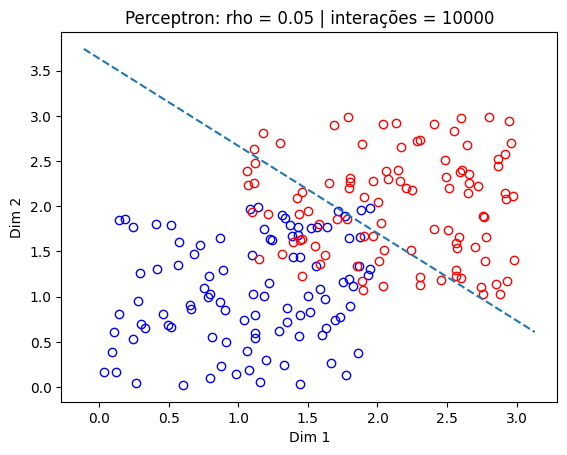

None
Limite de interacoes atingido


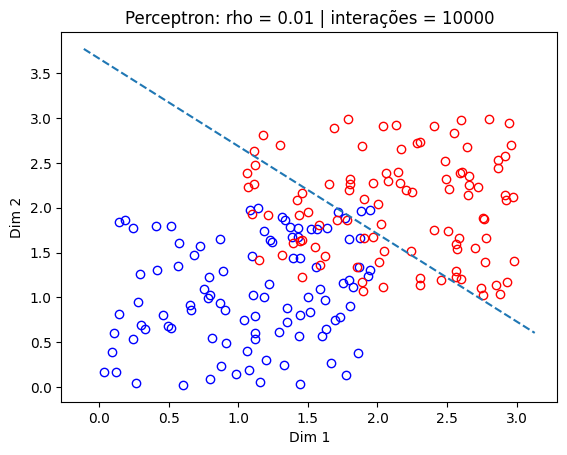

None


In [21]:
# aplicacao do perceptron entre a classe 1 e variantes da classe 2
# testando com rho 0.05 e 0.01

rho = [0.05, 0.01]
for index in range(len(rho)):
  ws_12d, hs_12d, t_12d = t6_perceptron(class_1, class_2d, rho=rho[index],maxsteps=10000)
  print(t6_plotaperceptron(class_1, class_2d, ws_12d, f"Perceptron: rho = {rho[index]} | interações = {t_12d}", angulo=(-140, 40)))

Podemos concluir, geralmente, o maior passo precisa de menos interação para chegar em um plano que separa as duas classes do que um passo mais preciso. Contudo, é possível notar que quando há mais interação, o plano tende a ficar mais próximo de uma classe do que outra. Outro ponto importante também, é que como a classe 2D não é separável da classe 1, o perceptron atinge a interação máxima de 10 mil - justamente por não convergir - e não acabar separando as classes e classificando de forma errônea alguns padrões.

# Least Square

**2) [LS]:** No github do curso, método t7_LS, você encontrará uma função simples que implementa oclassificador baseado no critério do menor erro quadrado (Least Squares ou LS) entre duas classes. A função recebe duas matrizes correspondendo a dados provenientes de duas classes distintas. As matrizes devem ter o mesmo número de características (L), mas podem ter números de padrões distintos. A função também recebe o parâmetro de regularização da inversão matricial (α). O algoritmo retorna o vetor com os pesos do classificador linear ( em L+1 dimensões).

**a)** Leia com calma a função para garantir que você compreende o que está sendo feito.

**b)** Agora vamos testá-la utilizando os dados do exercício 3 da Aula 10 (PCA).

In [120]:
# gerando os dados
medias = np.array([[-6, 6, 6],[6, 6, 6]])
covariancias = np.zeros((2, 3, 3))
covariancias[0, :, :] = np.array([[0.3, 1, 1], [1, 9, 1], [1, 1, 9]])
covariancias[1, :, :] = np.array([[0.3, 1, 1], [1, 9, 1], [1, 1, 9]])
priors = np.array([1/2, 1/2])

data, classess = gerandodadosgaussianos(medias, covariancias, 400, priors, plotar=False, seed=0, angulo=[20, 120])